In [19]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [20]:
metadata = pd.read_csv("HAM10000_metadata.csv")

print("Columns in metadata:", metadata.columns)
print(metadata.head())


Columns in metadata: Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [21]:
from pathlib import Path
import glob

# Collect all image paths from both folders
image_paths = glob.glob("HAM10000_images_part_*/*.jpg")

# Create dictionary: {image_id: full_path}
path_dict = {Path(x).stem: x for x in image_paths}

# Add new column to metadata
metadata['image_path'] = metadata['image_id'].map(path_dict)

print(metadata[['image_id','dx','image_path']].head())
from pathlib import Path
import glob

# Collect all image paths from both folders
image_paths = glob.glob("HAM10000_images_part_*/*.jpg")

# Create dictionary: {image_id: full_path}
path_dict = {Path(x).stem: x for x in image_paths}

# Add new column to metadata
metadata['image_path'] = metadata['image_id'].map(path_dict)

print(metadata[['image_id','dx','image_path']].head())


       image_id   dx                               image_path
0  ISIC_0027419  bkl  HAM10000_images_part_1\ISIC_0027419.jpg
1  ISIC_0025030  bkl  HAM10000_images_part_1\ISIC_0025030.jpg
2  ISIC_0026769  bkl  HAM10000_images_part_1\ISIC_0026769.jpg
3  ISIC_0025661  bkl  HAM10000_images_part_1\ISIC_0025661.jpg
4  ISIC_0031633  bkl  HAM10000_images_part_2\ISIC_0031633.jpg
       image_id   dx                               image_path
0  ISIC_0027419  bkl  HAM10000_images_part_1\ISIC_0027419.jpg
1  ISIC_0025030  bkl  HAM10000_images_part_1\ISIC_0025030.jpg
2  ISIC_0026769  bkl  HAM10000_images_part_1\ISIC_0026769.jpg
3  ISIC_0025661  bkl  HAM10000_images_part_1\ISIC_0025661.jpg
4  ISIC_0031633  bkl  HAM10000_images_part_2\ISIC_0031633.jpg


In [22]:
IMG_SIZE = 64  

def load_images(df, img_size=IMG_SIZE):
    images = []
    labels = []
    for i, row in df.iterrows():
        path = row['image_path']
        if path and os.path.exists(path):
            img = cv2.imread(path)          # read image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert BGR → RGB
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(row['dx'])
        else:
            print("Missing:", row['image_id'])
    return np.array(images), np.array(labels)

X, y = load_images(metadata)

print("Images shape:", X.shape, "Labels shape:", y.shape)


Images shape: (10015, 64, 64, 3) Labels shape: (10015,)


In [23]:
X = X / 255.0   # normalize

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded, num_classes=len(le.classes_))

print("Classes:", le.classes_)


Classes: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (8012, 64, 64, 3) Test: (2003, 64, 64, 3)


In [25]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


C:\Users\chait\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 684,103 (2.61 MB)

 Trainable params: 684,103 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.6666 - loss: 1.1294 - val_accuracy: 0.6695 - val_loss: 0.9932
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.6706 - loss: 0.9940 - val_accuracy: 0.6700 - val_loss: 0.9119
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.6741 - loss: 0.9327 - val_accuracy: 0.6705 - val_loss: 0.9062
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.6801 - loss: 0.8801 - val_accuracy: 0.6835 - val_loss: 0.8763
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.6831 - loss: 0.8529 - val_accuracy: 0.7039 - val_loss: 0.8270
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.6925 - loss: 0.8328 - val_accuracy: 0.7099 - val_loss: 0.7885
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.6982 - loss: 0.8067 - val_accuracy: 0.7044 - val_loss: 0.7808
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7088 - loss: 0.7813 - 

In [27]:
loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {acc*100:.2f}%")


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7364 - loss: 0.7449
✅ Test Accuracy: 73.64%


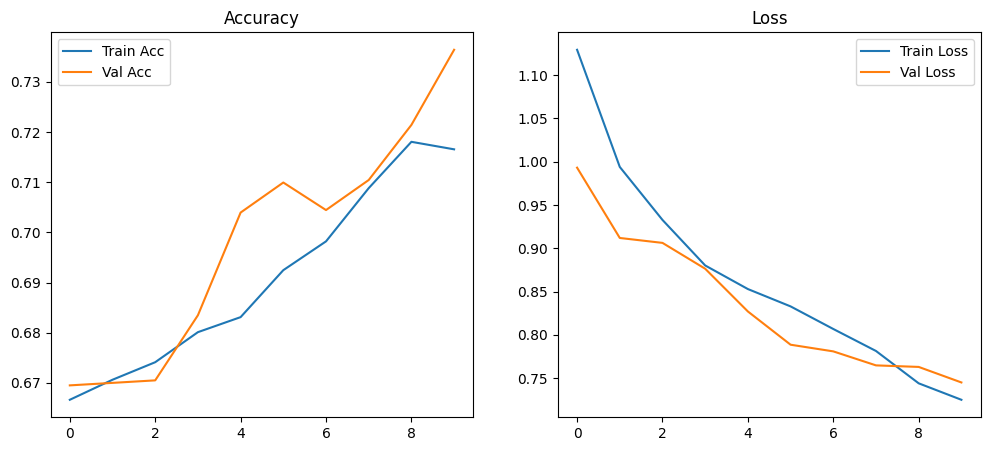

In [28]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend()
plt.title("Accuracy")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()
